# Demonstration of projection prediction using SVM on averaged odor activity

**Purpose**: This notebook demonstrates how to decode projection target based on averaged fluorescence activity per odor.

This can serve as a baseline to compare with more complicated models, such as a neural network or transformer models (e.g. GAFormer) 
that can take into account all trials and time points at the same time, or even further about stimulus or trial metadata.

**Prerequisite**: This notebook assumes the following notebooks are already run:
- [`process-passive-dataset.ipynb`](process-passive-dataset.ipynb)
- [`process-GNG-dataset.ipynb`](process-GNG-dataset.ipynb)

And it assumes the processed data files have already been time-aligned and saved.

The notebook assumes the processed files are saved as `pq[.zst]` file format. 

If you choose a different format, please use the appropriate functions to load.

**Scope**: In this notebook the experiments that fall under the following can be used:

- `identity` (`data/proc/identity`)
- `concentration` (`data/proc/concentration`)
- `GNG` (`data/proc/GNG`)


## 1. Import package & define paths

### 1.1. Import packages

In [1]:
import os
import warnings
import re
import yaml
from functools import partial
from itertools import combinations, product

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

from sklearn import (
    preprocessing,
    dummy,
    svm,
    neural_network,
    manifold,
    metrics,
    model_selection,
    pipeline,
)

from sklearn.base import clone as skclone

In [2]:
# change working dir to top of repo
_nb_cur_dir = os.getcwd()
_repo_name = 'projection-difference'
if os.path.basename(_nb_cur_dir) != _repo_name:
    os.chdir(_nb_cur_dir[:re.search(_repo_name, _nb_cur_dir).end()])    
assert os.path.basename(os.getcwd()) == _repo_name, (
    f'The current working directory of this notebook should be the repo "{_repo_name}",\n'
    f'and not "{_nb_cur_dir}".\n'
    f'Please use `%cd` or `os.chdir` to change to the top of repo'
)

# load utilities 
from src import nwb_processor as processor

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# configuration for plotting
plt.style.use('config/mpl.sty')

Matplotlib is building the font cache; this may take a moment.


In [4]:
MAX_WORKERS = len(os.sched_getaffinity(0))
MAX_WORKERS

32

### 1.2. Define data paths

Again, this notebook asssumes:
1. Normalized fluorescence files are saved as `pq[.zst]` files
2. Time alignment is already taken care of in the `process...` notebooks

<div class="alert alert-info">

**Options**:

- If you saved as other file formats, please change `fluo_load_fn` and `data_suffix` accordingly
- Please change `fluo_norm` and `orc_criteria` if you used other choices during those `process...` notebooks
</div>

In [5]:
# file format and load function
data_load_fn = pd.read_parquet
data_suffix = 'pq.zst'

In [6]:
# norm method and ORC criteria
fluo_norm = 'percdFF'
orc_criteria = 'min_3_sessions'

In [7]:
data_paths = {
    'identity': {
        'dFF': f'data/proc/identity/identity__{fluo_norm}.{data_suffix}'
    },
    'concentration': {
        'dFF': f'data/proc/concentration/concentration__{fluo_norm}.{data_suffix}',
    },
    'GNG': {
        'cell_metadata': f'data/proc/GNG/GNG__cell-metadata.{data_suffix}',
        'dFF': f'data/proc/GNG/GNG__{fluo_norm}.{data_suffix}',
        'orc': f'data/proc/GNG/GNG__{orc_criteria}-orc__{orc_criteria}.{data_suffix}'
    }
}

data_paths

{'identity': {'dFF': 'data/proc/identity/identity__percdFF.pq.zst'},
 'concentration': {'dFF': 'data/proc/concentration/concentration__percdFF.pq.zst'},
 'GNG': {'cell_metadata': 'data/proc/GNG/GNG__cell-metadata.pq.zst',
  'dFF': 'data/proc/GNG/GNG__percdFF.pq.zst',
  'orc': 'data/proc/GNG/GNG__min_3_sessions-orc__min_3_sessions.pq.zst'}}

## 2. Passive `identity` experiment

### 2.1. Compute aggregated response

In [8]:
def compute_aggregated_response(
    experiment = 'identity',
    bin_start = 0,
    bin_stop = 15,
    bin_width = 0.5,
    time_agg_fn = np.mean,
    trial_agg_fn = np.mean, 
    metadata_cols = [
        'exp_id', 'subject_id', 'proj_area', 'date_id',
        'cell_id', 'projection', 'is_redcell',
        'stim_id', 
    ]
):        
    """
    Compute aggregated response (both by time and then trial) for each experiment
    
    Parameters
    ----------
    experiment: the name of experiment based on `data_paths` defined above
    bin_start, bin_stop, bin_width: parameters to define time windows to aggregated within a trial
    time_agg_fn: function to aggregate response within a trial
    trial_agg_fn: function to aggregate response across trials within a session
    metadata_cols: metadata columns that define the constant variables *not* to be aggregated across

    Returns
    -------
    A dataframe with aggregated response across time and trial for each combination of `metadata_cols`
    """
    
    assert (
        'trial_id' not in metadata_cols and 
        'trial' not in metadata_cols
    ), (
        '"trial_id" and "trial" columns should not be in `metadata_cols`, '
        'because the output is trial-aggregated (e.g. via averaging) response. '
        'However, it is ok to have columns that signify metadata about trials'
    )
    
    df = data_load_fn(data_paths[experiment]['dFF'])
    
    assert (
        not df['is_bad_trial'].any() and
        all(df['stim_type'].unique() == 'odor')
    ), 'Bad trials or trials with non-odor stimuli still remain in dataframe, please remove'
    
    # get only aligned times / frames
    if 'rel_time' in df.columns:
        assert (
            all(df['t'].apply(len) == df['rel_time'].apply(len)) and
            all(df['dFF0'].apply(len) == df['rel_time'].apply(len))
        ), 'Mismatch dimension in time series, possibly because not aligned yet'
        df['t'] = df.pop('rel_time')
        if 'keep_frame_vec' in df.columns:
            df.drop(columns=['keep_frame_vec'], inplace=True)
    else:
        # align to stim onset
        df['t'] = df.apply(
            lambda x: x['t'] - x['stim_onset_frame'] * (x['t'][1] - x['t'][0]),
            axis=1
        )
        
    # get only projection neurons
    df = df.query('is_redcell == True').reset_index(drop=True)
    
    # discrete binning to compute response
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)
    bin_edges = list(zip(bin_edges[:-1],bin_edges[1:]))
    
    # use matrix for faster computation
    t_mat = np.vstack(df['t'].to_list())
    fluo_mat = np.vstack(df['dFF0'].to_list())
    
    # compute time-aggregated first, then trial-aggregated
    agg_df = []
    for t_start, t_stop in tqdm(bin_edges):
        # metadata
        agg_df_bin = df.filter(metadata_cols).copy()
    
        # time-aggregated
        agg_df_bin['response'] = np.array([
            time_agg_fn(f[i]) for f, i in zip(
                fluo_mat, 
                (t_mat >= t_start) & (t_mat < t_stop)
            )
        ])
        
        # trial-aggregated
        agg_df.append(
            agg_df_bin
            .groupby(metadata_cols)
            ['response']
            .apply(trial_agg_fn)
            .reset_index()
            .assign(
                t_start = t_start,
                t_stop = t_stop,
            )
        )
    
    agg_df = pd.concat(agg_df, ignore_index=True)
    agg_df['window'] = agg_df.apply(lambda x: (x['t_start'], x['t_stop']), axis=1)
    return agg_df

The following returns a dataframe such that, for each projection-labeled cell in the `identity` experiment:
- for each trial compute the time-averaged fluorescence based on the time bins / windows:
    - each window is ~ 500-ms
    - starting from stim onset (i.e. 0)
    - to 15 seconds afterwards
    - non overlapping bins
- then, for each `stim_id`, compute the averaged response for each of those above time bins / windows

In [9]:
agg_df = compute_aggregated_response(
    experiment = 'identity',
    bin_start = 0,
    bin_stop = 15,
    bin_width = 0.5,
    time_agg_fn = np.mean,
    trial_agg_fn = np.mean, 
    metadata_cols = [
        'exp_id', 'subject_id', 'proj_area', 'date_id',
        'cell_id', 'projection', 'is_redcell',
        'stim_id', # change or add columns to average / aggregate by, e.g. other stim / trial metadata
    ]
)

agg_df

  0%|          | 0/30 [00:00<?, ?it/s]

exp_id  subject_id proj_area   date_id  cell_id projection  \
0        OB_163_20200227         163        OB  20200227        5         OB   
1        OB_163_20200227         163        OB  20200227        5         OB   
2        OB_163_20200227         163        OB  20200227        5         OB   
3        OB_163_20200227         163        OB  20200227        5         OB   
4        OB_163_20200227         163        OB  20200227        5         OB   
...                  ...         ...       ...       ...      ...        ...   
39595  mPFC_644_20210511         644      mPFC  20210511      367       mPFC   
39596  mPFC_644_20210511         644      mPFC  20210511      367       mPFC   
39597  mPFC_644_20210511         644      mPFC  20210511      367       mPFC   
39598  mPFC_644_20210511         644      mPFC  20210511      367       mPFC   
39599  mPFC_644_20210511         644      mPFC  20210511      367       mPFC   

       is_redcell  stim_id  response  t_start  t_stop        window  
0            True        1  1.468259      0.0     0.5    (0.0, 0.5)  
1            True        2  1.317017      0.0     0.5    (0.0, 0.5)  
2            True        3  0.637568      0.0     0.5    (0.0, 0.5)  
3            True        4  1.509680      0.0     0.5    (0.0, 0.5)  
4            True        5  0.902795      0.0     0.5    (0.0, 0.5)  
...           ...      ...       ...      ...     ...           ...  
39595        True        4  0.936244     14.5    15.0  (14.5, 15.0)  
39596        True        5  0.450321     14.5    15.0  (14.5, 15.0)  
39597        True        6  0.763628     14.5    15.0  (14.5, 15.0)  
39598        True        7  0.289891     14.5    15.0  (14.5, 15.0)  
39599        True        8  0.629911     14.5    15.0  (14.5, 15.0)  

[39600 rows x 12 columns]

### 2.2. Demonstrate projection decoding

The following selects for time bin where its start is at 2 seconds (relative to stim onset).

Then reshapes (i.e. pivot) to form a feature table.


#### 2.2.1. Featrue construction from a time bin

In [10]:
select_df = (
    agg_df
    .query('t_start == 2.0')
    .reset_index(drop=True)
    .pivot(
        index=['subject_id', 'cell_id', 'projection'],
        columns='stim_id',
        values='response'
    )
)

select_df


stim_id                               1         2         3         4  \
subject_id cell_id projection                                           
8          2       OB          0.320965  0.097851  0.743170  0.329305   
           11      OB          0.823047  0.857509  0.385778  0.745711   
           29      OB          1.040641  0.441786  1.285070  1.997666   
           35      OB          0.662426  0.751738  0.704968  2.060758   
           47      OB          0.208361  0.507847  1.010364  0.787145   
...                                 ...       ...       ...       ...   
644        254     mPFC        0.809618  0.825154  0.600633  0.239637   
           282     mPFC        0.591651  0.550034  1.124279  0.129941   
           284     mPFC        0.878883  0.816975  0.438035  0.619801   
           292     mPFC        0.642593  0.765552  0.618071  0.856515   
           367     mPFC        0.829783  0.408450  0.845714  0.155425   

stim_id                               5         6         7         8  
subject_id cell_id projection                                          
8          2       OB          0.458629  0.401644  0.316425  0.405961  
           11      OB          0.475359  0.885270  0.974046  0.767167  
           29      OB          1.257164  1.854350  1.794856  1.767952  
           35      OB          0.566930  0.926705  0.610793  0.388191  
           47      OB          0.238463  1.009088  0.349323  0.130757  
...                                 ...       ...       ...       ...  
644        254     mPFC        0.870747  0.493888  0.892741  0.569545  
           282     mPFC        0.318410  0.459367  0.985167  0.712355  
           284     mPFC        0.729774  0.569564  0.544058  0.659081  
           292     mPFC        0.605281  0.605296  0.457879  0.475660  
           367     mPFC        0.447594  0.447195  0.448281  0.595367  

[165 rows x 8 columns]

The input is averaged response for each odor stimulus.

The task of the decoder is to predict the projection targets (i.e. `projection` column)

In [11]:
X = np.vstack(select_df.values)
y = select_df.reset_index()['projection'].to_numpy()
g = select_df.reset_index()['subject_id'].to_numpy()

print(
    f'Dimensions:\n\tInput: {X.shape}\n'
    f'\tLabel: {y.shape}, with {len(set(y))} unique values\n'
    f'\tGroups / Subject: {g.shape}, with {len(set(g))} unique values'
)

Dimensions:
	Input: (165, 8)
	Label: (165,), with 2 unique values
	Groups / Subject: (165,), with 10 unique values


#### 2.2.2. Decode projection using SVM and dummy

One can use a simple linear SVM, whose performance is at 61.3%, whereas a dummy classifier (which can be considered as a null hypothesis / chance) performs about 51%

In [12]:
model_selection.cross_val_score(
    estimator = svm.SVC(kernel='linear'), 
    X = X, y = y, 
    cv = model_selection.RepeatedStratifiedKFold()
).mean()

0.6066666666666667

In [13]:
model_selection.cross_val_score(
    estimator = dummy.DummyClassifier(),
    X = X, y = y, 
    cv = model_selection.RepeatedStratifiedKFold()
).mean()

0.509090909090909

#### 2.2.3. Decode with held-out subjects

In [14]:
def classify_with_groups(estimator, X, y, g):
    """
    Classification scores with all combinations of group held-out
    i.e. for each test, hold out 2 subjects in `g` and train on the rest

    Parameters
    ----------
    estimator: classifier object from `sklearn`
    X: input matrix 
    y: label vector
    g: group / subject vector

    Returns
    -------
    An array of accuracy scores
    """
    unq_y = np.unique(y)
    assert len(unq_y) == 2
    
    groups_y1 = np.unique(g[y == unq_y[0]])
    groups_y2 = np.unique(g[y == unq_y[1]])

    scores = []
    for g1, g2 in product(groups_y1, groups_y2):
        
        test_idx = np.isin(g, [g1, g2]) # hold out
        train_idx = ~test_idx
        
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        clf = skclone(estimator)
        clf.fit(X_train, y_train)
        scores.append(metrics.accuracy_score(
            y_test, clf.predict(X_test)
        ))
    scores = np.array(scores)
    return scores

A more robust evaluation for generalization is to hold out subjects (i.e. groups), train on the rest, then test on those held-out samples.

It is not required, especially since we do not have many subjects, esp. for GNG experiment.

However, it is good to at least perform this for comparison, and see whether the SVM performs better than the dummy classifier under hold-out.

With the same `X` and `y`, it is expected that the SVM performs worse. But it still performs better than the dummy classifier under the same hold-out testing.

In [15]:
classify_with_groups(
    estimator = svm.SVC(kernel='linear'),
    X = X, y = y, g = g
).mean()

0.5509672147607584

In [16]:
classify_with_groups(
    estimator = dummy.DummyClassifier(),
    X = X, y = y, g = g
).mean()

model_selection.StratifiedGroupKFold

sklearn.model_selection._split.StratifiedGroupKFold


Note: The reason for why dummy performs at 40%, rather than 50% is possibly because the class imbalance that cannot be easily controlled by stratification when splitting by groups, especially when we have very few groups. 

This can be improved with better stratification / class imbalance checks in `classify_with_groups` function or `sklearn.StratifiedGroupKFold` (though this does not seem to generate all satisfied splits at the moment).

#### 2.2.4. Decode projection using all time bins

Instead of using only 1 discrete window, one can also use all the computed bins / windows

In [17]:
select_df = agg_df.pivot(
    index=['cell_id','subject_id','projection'], 
    columns=['stim_id','t_start'],
    values='response'
)

select_df

stim_id                               1         2         3         4  \
t_start                            0.0       0.0       0.0       0.0    
cell_id subject_id projection                                           
0       9          OB          0.313219  0.299160  0.193278  0.191263   
        164        OB          0.501875  0.680910  0.170591  0.021103   
        512        mPFC        0.694928  0.725376  0.363664  0.375461   
        644        mPFC        0.331996  0.606602  0.452225  0.584628   
1       164        OB          0.362772  0.238619  0.101594  0.486127   
...                                 ...       ...       ...       ...   
303     163        OB          0.601719  0.764681  0.856932  0.646955   
318     163        OB          0.793991  0.257126  1.422452  0.458505   
328     163        OB          0.549630  0.390729  1.476769  0.559975   
329     163        OB          0.331677  1.478334  0.979281  1.130677   
367     644        mPFC        0.768736  0.363201  0.551690  0.240771   

stim_id                               5         6         7         8  \
t_start                            0.0       0.0       0.0       0.0    
cell_id subject_id projection                                           
0       9          OB          0.161402  0.122450  0.300047  0.186376   
        164        OB          0.567173  0.563197  0.167754  0.067314   
        512        mPFC        0.837279  0.447550  0.323871  0.607130   
        644        mPFC        0.187889  0.203896  0.160016  0.581650   
1       164        OB          0.501900  0.034003  1.025863  0.638506   
...                                 ...       ...       ...       ...   
303     163        OB          0.712261  0.263491  1.875029  0.268333   
318     163        OB          1.324445  0.347583  0.613851  0.325546   
328     163        OB          0.814915  0.538927  0.709996  0.314378   
329     163        OB          0.661272  0.674916  0.548223  0.856915   
367     644        mPFC        0.529689  0.156277  0.266125  0.607511   

stim_id                               1         2  ...         7         8  \
t_start                            0.5       0.5   ...      14.0      14.0   
cell_id subject_id projection                      ...                       
0       9          OB          0.355518  0.321807  ...  0.210411  0.153678   
        164        OB          0.591430  0.684263  ...  0.063417  0.028262   
        512        mPFC        0.733118  0.752795  ...  0.546023  1.400289   
        644        mPFC        0.314182  0.598321  ...  0.143812  0.657457   
1       164        OB          0.341046  0.256302  ...  0.863986  0.359079   
...                                 ...       ...  ...       ...       ...   
303     163        OB          0.502430  0.394215  ...  0.573635  1.223606   
318     163        OB          0.885084  0.241385  ...  1.293836  0.411525   
328     163        OB          0.505413  0.448536  ...  0.846919  0.689924   
329     163        OB          0.400252  1.462952  ...  0.602621  0.561758   
367     644        mPFC        0.835286  0.321629  ...  0.293577  0.651567   

stim_id                               1         2         3         4  \
t_start                            14.5      14.5      14.5      14.5   
cell_id subject_id projection                                           
0       9          OB          0.164535  1.072582  0.147113  0.154019   
        164        OB          1.049124  1.207635  0.382403  0.620539   
        512        mPFC        1.222676  0.442791  1.531904  0.940640   
        644        mPFC        0.493486  0.537337  3.561520  0.249025   
1       164        OB          0.492709  0.323972  0.214219  0.548897   
...                                 ...       ...       ...       ...   
303     163        OB          0.662493  0.677559  0.581320  0.314221   
318     163        OB          0.430276  0.786557  0.667237  0.164618   
328     163        OB          0.852467  0.975394  1.95993

In [18]:
X = np.vstack(select_df.values)
X = (X - X.mean(axis=1,keepdims=True)) / X.std(axis=1,keepdims=True)
y = select_df.reset_index()['projection'].to_numpy()
g = select_df.reset_index()['subject_id'].to_numpy()

print(
    f'Dimensions:\n\tInput: {X.shape}\n'
    f'\tLabel: {y.shape}, with {len(set(y))} unique values\n'
    f'\tGroups / Subject: {g.shape}, with {len(set(g))} unique values'
)

Dimensions:
	Input: (165, 240)
	Label: (165,), with 2 unique values
	Groups / Subject: (165,), with 10 unique values


In [19]:
pd.Series({
    'SVM | no-group-split': model_selection.cross_val_score(estimator = svm.SVC(kernel='linear'), X = X, y = y, cv = model_selection.RepeatedStratifiedKFold()).mean(),
    'dummy | no-group-split': model_selection.cross_val_score(estimator = dummy.DummyClassifier(), X = X, y = y, cv = model_selection.RepeatedStratifiedKFold()).mean(),
    'SVM | group-split': classify_with_groups(estimator = svm.SVC(kernel='linear'), X = X, y = y, g = g).mean(),
    'dummy | group-split': classify_with_groups(estimator = dummy.DummyClassifier(), X = X, y = y, g = g).mean(),
})

SVM | no-group-split      0.753939
dummy | no-group-split    0.509091
SVM | group-split         0.630165
dummy | group-split       0.400936
dtype: float64

With using all the computed bins, we get 75% for SVM (still better than dummy ~51%).

The group held-out performance also increases, to 63%, and still better than dummy (40%)

### 2.3. Classify projections based for each time bin separately

The following functions perform both group held-out and without, using different variations on which columns to use as features, and using different classifiers

In [20]:
def _classify_one_var_(
    data,
    classifiers = dict(),
    cv = 4,
    metadata_cols = ['subject_id', 'cell_id', 'projection'],
    feature_cols = ['stim_id'],
    value_col = 'response',
    label_col = 'projection',
    group_col = 'subject_id',
):
    if not isinstance(feature_cols, list):
        feature_cols = [feature_cols]
        
    # get (meta)data
    metadata = data['metadata']

    metadata_cols = list(set(metadata_cols + [label_col, group_col]))
    
    df = data['df'].pivot_table(
        index=metadata_cols,
        columns=feature_cols,
        values=value_col
    )

    # get features, labels and groups
    assert len(classifiers) > 0
    X = np.vstack(df.values)
    y = df.reset_index()[label_col].to_numpy()
    g = df.reset_index()[group_col].to_numpy()
    
    # classify
    perf_df = []
    for clf_name, clf in classifiers.items():
        # w/o group splitting
        perf_df.append(dict(
            classifier = clf_name,
            group_split = False,
            scores = model_selection.cross_val_score(
                estimator = clf, X = X, y = y, cv = cv
            )
        ))
        
        # with group splitting
        perf_df.append(dict(
            classifier = clf_name,
            group_split = True,
            scores = classify_with_groups(
                estimator = clf, X = X, y = y, g = g
            )
        ))

    # compute summay of scores
    perf_df = pd.DataFrame(perf_df)
    perf_df['avg_score'] = perf_df['scores'].apply(np.mean)
    perf_df['std_score'] = perf_df['scores'].apply(np.std)

    # metadata
    perf_df = perf_df.assign(
        **metadata,
        feature_dim = X.shape[1],
        feature_cols = ' & '.join(feature_cols)
    )
    return perf_df

def classify_projections(
    agg_df,
    variations,
    **kwargs
):
    perf_df = []
    for var_dict in tqdm(variations):
        feature_cols = var_dict['feature_cols']
        groupby_cols = var_dict.get('groupby_cols', None)
        init_query_str = var_dict.get('init_query_str', None)

        if groupby_cols is not None:
            groupby_df = agg_df.groupby(groupby_cols)
            if init_query_str:
                groupby_df = (
                    agg_df.query(init_query_str)
                    .groupby(groupby_cols)
                )
                
            group_data = [
                {
                    'metadata': dict(zip(
                        groupby_cols, 
                        (g if type(g) in (list,tuple,set) else [g])
                    )),
                    'df': groupby_df.get_group(g)
                }
                for g in groupby_df.groups
            ]
        else:
            group_data = [
                {
                    'metadata': dict(),
                    'df': agg_df
                }
            ]
        
        perf_df.append(pd.concat(process_map(
            partial(
                _classify_one_var_,
                feature_cols = feature_cols,
                **kwargs
            ),
            group_data,
            max_workers=MAX_WORKERS,
            leave=False,
        ), ignore_index=True))
        
    perf_df = pd.concat(perf_df, ignore_index=True)
    
    return perf_df

In [21]:
# define classifiers, add more if needed
classifiers = {
    'SVM': svm.SVC(kernel='linear'),
    'dummy': dummy.DummyClassifier()
}

# this stratifier is only for non group-held-out evaluation
cv = model_selection.RepeatedStratifiedKFold(
    n_splits=4, n_repeats=10, 
    random_state=238347
)


# variations on how to build features
variations = [
    dict(
        feature_cols = ['stim_id',],
        groupby_cols = ['t_start', 't_stop',]
    ),
    dict(
        feature_cols = ['stim_id', 't_start'],
    ),
]

# run classifications
perf_df = classify_projections(
    agg_df,
    variations,
    classifiers = classifiers,
    cv = cv
)

perf_df

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

classifier  group_split  \
0          SVM        False   
1          SVM         True   
2        dummy        False   
3        dummy         True   
4          SVM        False   
..         ...          ...   
119      dummy         True   
120        SVM        False   
121        SVM         True   
122      dummy        False   
123      dummy         True   

                                                scores  avg_score  std_score  \
0    [0.5952380952380952, 0.7073170731707317, 0.560...   0.598795   0.057148   
1    [0.625, 0.5925925925925926, 0.75, 0.5555555555...   0.487299   0.120954   
2    [0.5, 0.5121951219512195, 0.5121951219512195, ...   0.509146   0.005281   
3    [0.4166666666666667, 0.37037037037037035, 0.41...   0.400936   0.079775   
4    [0.6428571428571429, 0.7804878048780488, 0.634...   0.649114   0.067877   
..                                                 ...        ...        ...   
119  [0.4166666666666667, 0.37037037037037035, 0.41...   0.400936   0.079775   
120  [0.7619047619047619, 0.7804878048780488, 0.780...   0.757056   0.042612   
121  [0.4583333333333333, 0.7037037037037037, 0.625...   0.619224   0.092463   
122  [0.5, 0.5121951219512195, 0.5121951219512195, ...   0.509146   0.005281   
123  [0.4166666666666667, 0.37037037037037035, 0.41...   0.400936   0.079775   

     t_start  t_stop  feature_dim       feature_cols  
0        0.0     0.5            8            stim_id  
1        0.0     0.5            8            stim_id  
2        0.0     0.5            8            stim_id  
3        0.0     0.5            8            stim_id  
4        0.5     1.0            8            stim_id  
..       ...     ...          ...                ...  
119     14.5    15.0            8            stim_id  
120      NaN     NaN          240  stim_id & t_start  
121      NaN     NaN          240  stim_id & t_start  
122      NaN     NaN          240  stim_id & t_start  
123      NaN     NaN          240  stim_id & t_start  

[124 rows x 9 columns]

### 2.4. Visualize performance

In [22]:
# this is for visualization purposes
perf_df['title_group_split'] = perf_df['group_split'].map({
    False: 'no subject holdout',
    True: 'with subject holdout',
})

#### 2.4.1. Visualize performance of SVM trained on each discrete window separately

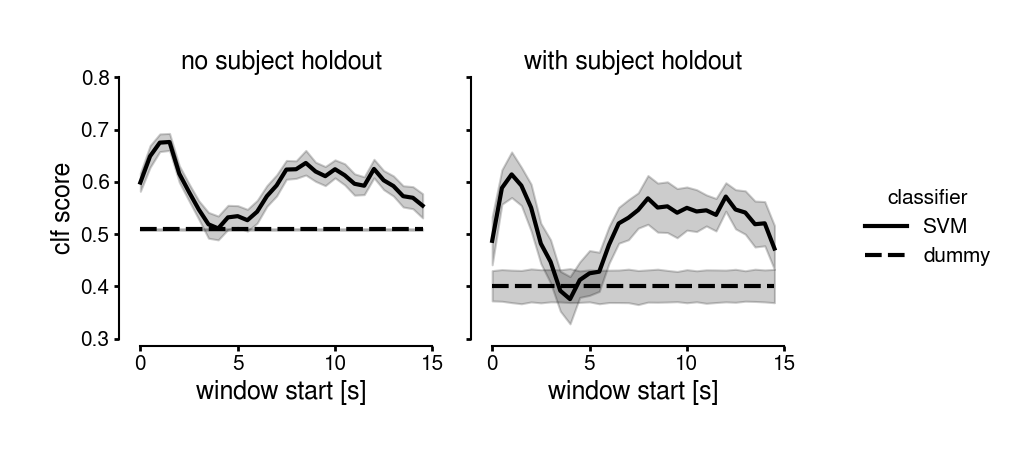

In [23]:
g = sns.relplot(
    (
        perf_df
        .query('feature_cols == "stim_id"')
        .explode('scores')
    ),
    x='t_start',
    y='scores',
    col = 'title_group_split',
    kind = 'line',
    style = 'classifier',
    height = 4,
    linewidth = 3,
    color  = 'k',
)
plt.ylim([0.3, 0.8])

g.set_titles(
    '{col_name}'
)
g.set_xlabels('window start [s]')
g.set_ylabels('clf score')
g.despine(trim=True, offset=5)
g.tight_layout()

This graph suggests that with and without group-hold out, there are two separate periods where SVM can decode projection targets based on discrete window averaged odor activity:
- early (before ~3 seconds after stim onset)
- and late (after 6-ish seconds lasting for even about 15 seconds)

#### 2.4.2. Visualize performance of SVM trained all discrete windows


In [24]:
perf_df.query('feature_cols.str.contains("\&")')

classifier  group_split  \
120        SVM        False   
121        SVM         True   
122      dummy        False   
123      dummy         True   

                                                scores  avg_score  std_score  \
120  [0.7619047619047619, 0.7804878048780488, 0.780...   0.757056   0.042612   
121  [0.4583333333333333, 0.7037037037037037, 0.625...   0.619224   0.092463   
122  [0.5, 0.5121951219512195, 0.5121951219512195, ...   0.509146   0.005281   
123  [0.4166666666666667, 0.37037037037037035, 0.41...   0.400936   0.079775   

     t_start  t_stop  feature_dim       feature_cols     title_group_split  
120      NaN     NaN          240  stim_id & t_start    no subject holdout  
121      NaN     NaN          240  stim_id & t_start  with subject holdout  
122      NaN     NaN          240  stim_id & t_start    no subject holdout  
123      NaN     NaN          240  stim_id & t_start  with subject holdout

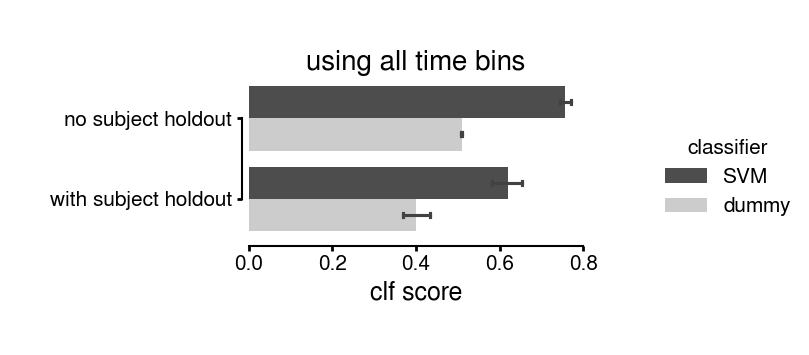

In [25]:
g = sns.catplot(
    (
        perf_df
        .query('feature_cols.str.contains("\&")')
        .explode('scores')
    ),
    x='scores',
    y='title_group_split',
    hue= 'classifier',
    palette=['.3','.8'],
    kind = 'bar',
    capsize=0.1,
    height = 3,
    aspect = 2,
    linewidth = 2,
)

plt.xlim([0.0, 0.8])
plt.xlabel('clf score')
plt.ylabel(None)
plt.title('using all time bins')

g.despine(trim=True, offset=5)
g.tight_layout()

Again, using all time windows allow the SVM to better decode projection targets (compared to a dummy classifier), even with group hold out

## 3. Passive `concentration` experiment

### 3.1. Compute aggregated response

You can repeat the above procedures using `stim_id` to decode.

In the following sections, instead of using `stim_id`, we will average for each stimulus class (`A`,`B`,`C`) and each concentration level (`low`,`medium`,`high`). 
    
Essentially, this is to faciliate, later, for each stimulus class, if we use the concentration-dependent responses, can we decode projection targets?

In [26]:
agg_df = compute_aggregated_response(
    experiment = 'concentration',
    bin_start = 0,
    bin_stop = 15,
    bin_width = 0.5,
    time_agg_fn = np.mean,
    trial_agg_fn = np.mean, 
    metadata_cols = [
        'exp_id', 'subject_id', 'proj_area', 'date_id',
        'cell_id', 'projection', 'is_redcell',
        # 'stim_id',
        'stim_class', 'stim_conc'
    ]
)

agg_df

  0%|          | 0/30 [00:00<?, ?it/s]

exp_id  subject_id proj_area   date_id  cell_id projection  \
0       OB_2372_20230816        2372        OB  20230816        9         OB   
1       OB_2372_20230816        2372        OB  20230816        9         OB   
2       OB_2372_20230816        2372        OB  20230816        9         OB   
3       OB_2372_20230816        2372        OB  20230816        9         OB   
4       OB_2372_20230816        2372        OB  20230816        9         OB   
...                  ...         ...       ...       ...      ...        ...   
51025  mPFC_644_20210427         644      mPFC  20210427      380       mPFC   
51026  mPFC_644_20210427         644      mPFC  20210427      380       mPFC   
51027  mPFC_644_20210427         644      mPFC  20210427      380       mPFC   
51028  mPFC_644_20210427         644      mPFC  20210427      380       mPFC   
51029  mPFC_644_20210427         644      mPFC  20210427      380       mPFC   

       is_redcell stim_class stim_conc  response  t_start  t_stop  \
0            True          A      high  0.328145      0.0     0.5   
1            True          A       low  0.983823      0.0     0.5   
2            True          A    medium  0.144533      0.0     0.5   
3            True          B      high  0.421401      0.0     0.5   
4            True          B       low  1.052027      0.0     0.5   
...           ...        ...       ...       ...      ...     ...   
51025        True          B       low  0.895818     14.5    15.0   
51026        True          B    medium  0.873864     14.5    15.0   
51027        True          C      high  0.919427     14.5    15.0   
51028        True          C       low  0.627909     14.5    15.0   
51029        True          C    medium  0.384332     14.5    15.0   

             window  
0        (0.0, 0.5)  
1        (0.0, 0.5)  
2        (0.0, 0.5)  
3        (0.0, 0.5)  
4        (0.0, 0.5)  
...             ...  
51025  (14.5, 15.0)  
51026  (14.5, 15.0)  
51027  (14.5, 15.0)  
51028  (14.5, 15.0)  
51029  (14.5, 15.0)  

[51030 rows x 13 columns]

### 3.2. Decode projection based on concentrations, for each odorant identity / class separately

In [27]:
variations = [
    dict(
        feature_cols = ['stim_conc'],
        groupby_cols = ['stim_class', 't_start', 't_stop',]
    ),
    dict(
        feature_cols = ['stim_conc', 't_start'],
        groupby_cols = ['stim_class',]
    ),
]

# run classifications
perf_df = classify_projections(
    agg_df,
    variations,
    classifiers = classifiers,
    cv = cv
)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [28]:
perf_df

classifier  group_split  \
0          SVM        False   
1          SVM         True   
2        dummy        False   
3        dummy         True   
4          SVM        False   
..         ...          ...   
367      dummy         True   
368        SVM        False   
369        SVM         True   
370      dummy        False   
371      dummy         True   

                                                scores  avg_score  std_score  \
0    [0.6041666666666666, 0.5531914893617021, 0.510...   0.551928   0.050615   
1    [0.47368421052631576, 0.4864864864864865, 0.68...   0.520733   0.075058   
2    [0.5416666666666666, 0.5531914893617021, 0.531...   0.539672   0.008762   
3    [0.47368421052631576, 0.4594594594594595, 0.6,...   0.520171   0.082444   
4    [0.6041666666666666, 0.5957446808510638, 0.446...   0.568894   0.053706   
..                                                 ...        ...        ...   
367  [0.47368421052631576, 0.4594594594594595, 0.6,...   0.520171   0.082444   
368  [0.6666666666666666, 0.6595744680851063, 0.617...   0.606206   0.067487   
369  [0.47368421052631576, 0.5135135135135135, 0.58...   0.467002   0.093825   
370  [0.5416666666666666, 0.5531914893617021, 0.531...   0.539672   0.008762   
371  [0.47368421052631576, 0.4594594594594595, 0.6,...   0.520171   0.082444   

    stim_class  t_start  t_stop  feature_dim         feature_cols  
0            A      0.0     0.5            3            stim_conc  
1            A      0.0     0.5            3            stim_conc  
2            A      0.0     0.5            3            stim_conc  
3            A      0.0     0.5            3            stim_conc  
4            A      0.5     1.0            3            stim_conc  
..         ...      ...     ...          ...                  ...  
367          B      NaN     NaN           90  stim_conc & t_start  
368          C      NaN     NaN           90  stim_conc & t_start  
369          C      NaN     NaN           90  stim_conc & t_start  
370          C      NaN     NaN           90  stim_conc & t_start  
371          C      NaN     NaN           90  stim_conc & t_start  

[372 rows x 10 columns]

### 3.3. Visualize decoding performance

In [29]:
# this is for visualization purposes
perf_df['title_group_split'] = perf_df['group_split'].map({
    False: 'no subject holdout',
    True: 'with subject holdout',
})

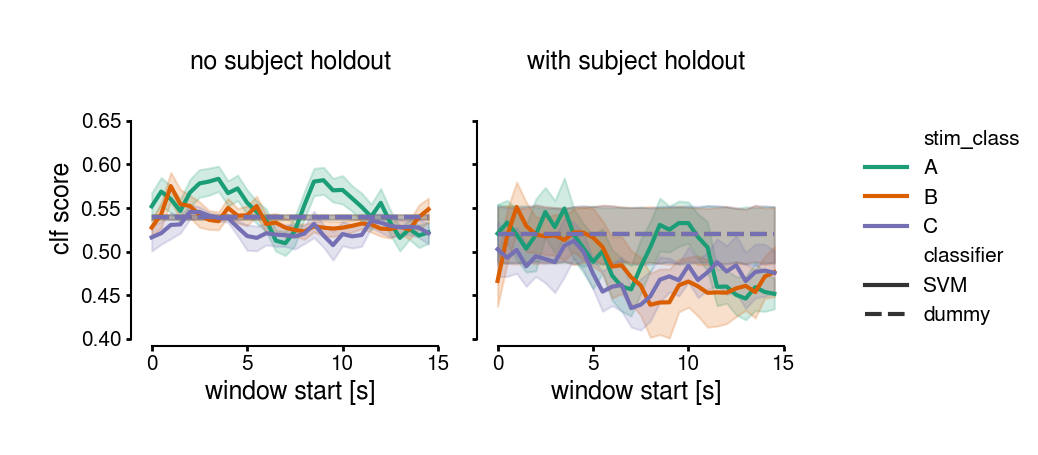

In [30]:
g = sns.relplot(
    (
        perf_df
        .query('feature_cols == "stim_conc"')
        .explode('scores')
    ),
    x='t_start',
    y='scores',
    hue = 'stim_class',
    col = 'title_group_split',
    style = 'classifier',
    palette = 'Dark2',
    kind = 'line',
    height = 4,
    linewidth = 3,
)

plt.ylim([0.4, 0.7])

g.set_titles('{col_name}')
g.set_xlabels('window start [s]')
g.set_ylabels('clf score')
g.despine(trim=True, offset=5)
g.tight_layout()

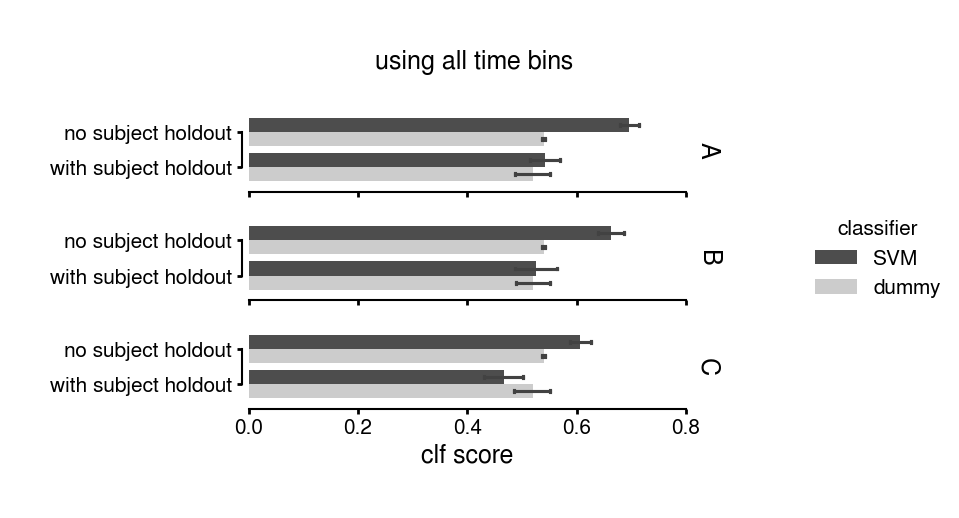

In [31]:
g = sns.catplot(
    (
        perf_df
        .query('feature_cols.str.contains("\&")')
        .explode('scores')
    ),
    x='scores',
    y='title_group_split',
    hue= 'classifier',
    row='stim_class',
    palette=['.3','.8'],
    kind = 'bar',
    capsize=0.1,
    height = 1.5,
    aspect = 5,
    linewidth = 2,
    margin_titles=True
)

plt.xlim([0.0, 0.8])
g.set_xlabels('clf score')
g.set_ylabels('')
g.fig.suptitle('using all time bins')
g.set_titles(row_template='{row_name}')
g.despine(trim=True, offset=5)
g.tight_layout()

Here, since the number of features decreases compared to using `stim_id`, it is expected that the performance decreases.

However, the performance still suggests that concentration-dependent responses can differentiate projection targets, especially for **A** and **B**, and still with early and late periods in the trial. 

But it is not generalizable with subject hold out. 

## 4. Go/NoGo experiment (`GNG`)

### 4.1. Compute aggregated responses

For GNG dataset, we are going to add additional metadata columns that can be useful to construct different types of feature combinations

In [32]:
agg_df = compute_aggregated_response(
    experiment = 'GNG',
    bin_start = 0,
    bin_stop = 15,
    bin_width = 0.5,
    time_agg_fn = np.mean,
    trial_agg_fn = np.mean, 
    metadata_cols = [
        'exp_id', 'subject_id', 'proj_area',
        'date_id',  'day_num',
        'cell_id', 'projection', 'is_redcell',
        'stim_name_value', 'stim_valence', 'action'
    ]
)

  0%|          | 0/30 [00:00<?, ?it/s]

For now, we're interested in learning so we'll select for `day > 0`

In [33]:
agg_df = agg_df.query('day_num > 0').reset_index(drop=True)
agg_df

exp_id  subject_id proj_area   date_id  day_num  cell_id  \
0        OB_2400_20230823        2400        OB  20230823        1        3   
1        OB_2400_20230823        2400        OB  20230823        1        3   
2        OB_2400_20230823        2400        OB  20230823        1        3   
3        OB_2400_20230823        2400        OB  20230823        1        3   
4        OB_2400_20230823        2400        OB  20230823        1        3   
...                   ...         ...       ...       ...      ...      ...   
129025  mPFC_644_20210819         644      mPFC  20210819        3      258   
129026  mPFC_644_20210819         644      mPFC  20210819        3      258   
129027  mPFC_644_20210819         644      mPFC  20210819        3      258   
129028  mPFC_644_20210819         644      mPFC  20210819        3      258   
129029  mPFC_644_20210819         644      mPFC  20210819        3      258   

       projection  is_redcell stim_name_value stim_valence     action  \
0              OB        True            CS+1       reward    correct   
1              OB        True            CS+1       reward  incorrect   
2              OB        True            CS+2       reward    correct   
3              OB        True            CS+2       reward  incorrect   
4              OB        True            CS-1         none    correct   
...           ...         ...             ...          ...        ...   
129025       mPFC        True            CS+2       reward  incorrect   
129026       mPFC        True            CS-1         none    correct   
129027       mPFC        True            CS-1         none  incorrect   
129028       mPFC        True            CS-2         none    correct   
129029       mPFC        True            CS-2         none  incorrect   

        response  t_start  t_stop        window  
0       0.421114      0.0     0.5    (0.0, 0.5)  
1       0.304325      0.0     0.5    (0.0, 0.5)  
2       0.441935      0.0     0.5    (0.0, 0.5)  
3       0.690928      0.0     0.5    (0.0, 0.5)  
4       0.469666      0.0     0.5    (0.0, 0.5)  
...          ...      ...     ...           ...  
129025  0.306849     14.5    15.0  (14.5, 15.0)  
129026  0.688951     14.5    15.0  (14.5, 15.0)  
129027  0.445722     14.5    15.0  (14.5, 15.0)  
129028  0.671422     14.5    15.0  (14.5, 15.0)  
129029  0.596581     14.5    15.0  (14.5, 15.0)  

[129030 rows x 15 columns]

### 4.2. Decode projection based on different features

In [34]:
variations = [
    # feat from odorant identity
    dict(
        feature_cols = ['stim_name_value'],
        groupby_cols = ['day_num', 't_start', 't_stop',]
    ),
    dict(
        feature_cols = ['stim_name_value', 't_start'],
        groupby_cols = ['day_num']
    ),
    # feat from odorant valence
    dict(
        feature_cols = ['stim_valence'],
        groupby_cols = ['day_num', 't_start', 't_stop',]
    ),
    dict(
        feature_cols = ['stim_valence', 't_start'],
        groupby_cols = ['day_num',]
    ),    
    # feat from odorant valence on correct trials
    dict(
        init_query_str = 'action == "correct"',
        feature_cols = ['stim_valence',],
        groupby_cols = ['day_num', 'action', 't_start', 't_stop',]
    ),
    dict(
        init_query_str = 'action == "correct"',
        feature_cols = ['stim_valence', 't_start'],
        groupby_cols = ['day_num', 'action']
    ),    
]

# run classifications
perf_df = classify_projections(
    agg_df,
    variations,
    classifiers = classifiers,
    cv = cv,
    metadata_cols = ['subject_id', 'cell_id', 'projection', 'day_num'],
)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
perf_df

classifier  group_split  \
0           SVM        False   
1           SVM         True   
2         dummy        False   
3         dummy         True   
4           SVM        False   
...         ...          ...   
1111      dummy         True   
1112        SVM        False   
1113        SVM         True   
1114      dummy        False   
1115      dummy         True   

                                                 scores  avg_score  std_score  \
0     [0.52, 0.54, 0.5, 0.5306122448979592, 0.54, 0....   0.533204   0.032377   
1     [0.4230769230769231, 0.4166666666666667, 0.365...   0.447813   0.051760   
2     [0.54, 0.54, 0.54, 0.5306122448979592, 0.54, 0...   0.537653   0.004065   
3     [0.38461538461538464, 0.4166666666666667, 0.38...   0.461179   0.054128   
4     [0.54, 0.54, 0.54, 0.5306122448979592, 0.54, 0...   0.529082   0.031624   
...                                                 ...        ...        ...   
1111  [0.40425531914893614, 0.4523809523809524, 0.32...   0.449165   0.072048   
1112  [0.5, 0.58, 0.68, 0.6530612244897959, 0.7, 0.6...   0.626061   0.069559   
1113  [0.5, 0.56, 0.5098039215686274, 0.433962264150...   0.454066   0.072387   
1114  [0.54, 0.54, 0.52, 0.5306122448979592, 0.54, 0...   0.532653   0.008250   
1115  [0.38461538461538464, 0.4, 0.39215686274509803...   0.454862   0.057853   

      day_num  t_start  t_stop  feature_dim            feature_cols   action  
0           1      0.0     0.5            4         stim_name_value      NaN  
1           1      0.0     0.5            4         stim_name_value      NaN  
2           1      0.0     0.5            4         stim_name_value      NaN  
3           1      0.0     0.5            4         stim_name_value      NaN  
4           1      0.5     1.0            4         stim_name_value      NaN  
...       ...      ...     ...          ...                     ...      ...  
1111        2      NaN     NaN           60  stim_valence & t_start  correct  
1112        3      NaN     NaN           60  stim_valence & t_start  correct  
1113        3      NaN     NaN           60  stim_valence & t_start  correct  
1114        3      NaN     NaN           60  stim_valence & t_start  correct  
1115        3      NaN     NaN           60  stim_valence & t_start  correct  

[1116 rows x 11 columns]

### 4.3. Visualize decoding performance

In [36]:
# this is for visualization purposes
perf_df['validation'] = perf_df['group_split'].map({
    False: 'no subject holdout',
    True: 'with subject holdout',
})

In [37]:
perf_df['feature_source'] = (
    (
        perf_df['feature_cols']
        .str.replace('stim_name_value', 'odor')
        .str.replace('stim_valence', 'val')
        .str.replace('t_start', 'bin')
    )
    + (
        perf_df['action']
        .apply(lambda x: '' if pd.isna(x) else ' | %s' %(x))
    )
)

perf_df

classifier  group_split  \
0           SVM        False   
1           SVM         True   
2         dummy        False   
3         dummy         True   
4           SVM        False   
...         ...          ...   
1111      dummy         True   
1112        SVM        False   
1113        SVM         True   
1114      dummy        False   
1115      dummy         True   

                                                 scores  avg_score  std_score  \
0     [0.52, 0.54, 0.5, 0.5306122448979592, 0.54, 0....   0.533204   0.032377   
1     [0.4230769230769231, 0.4166666666666667, 0.365...   0.447813   0.051760   
2     [0.54, 0.54, 0.54, 0.5306122448979592, 0.54, 0...   0.537653   0.004065   
3     [0.38461538461538464, 0.4166666666666667, 0.38...   0.461179   0.054128   
4     [0.54, 0.54, 0.54, 0.5306122448979592, 0.54, 0...   0.529082   0.031624   
...                                                 ...        ...        ...   
1111  [0.40425531914893614, 0.4523809523809524, 0.32...   0.449165   0.072048   
1112  [0.5, 0.58, 0.68, 0.6530612244897959, 0.7, 0.6...   0.626061   0.069559   
1113  [0.5, 0.56, 0.5098039215686274, 0.433962264150...   0.454066   0.072387   
1114  [0.54, 0.54, 0.52, 0.5306122448979592, 0.54, 0...   0.532653   0.008250   
1115  [0.38461538461538464, 0.4, 0.39215686274509803...   0.454862   0.057853   

      day_num  t_start  t_stop  feature_dim            feature_cols   action  \
0           1      0.0     0.5            4         stim_name_value      NaN   
1           1      0.0     0.5            4         stim_name_value      NaN   
2           1      0.0     0.5            4         stim_name_value      NaN   
3           1      0.0     0.5            4         stim_name_value      NaN   
4           1      0.5     1.0            4         stim_name_value      NaN   
...       ...      ...     ...          ...                     ...      ...   
1111        2      NaN     NaN           60  stim_valence & t_start  correct   
1112        3      NaN     NaN           60  stim_valence & t_start  correct   
1113        3      NaN     NaN           60  stim_valence & t_start  correct   
1114        3      NaN     NaN           60  stim_valence & t_start  correct   
1115        3      NaN     NaN           60  stim_valence & t_start  correct   

                validation       feature_source  
0       no subject holdout                 odor  
1     with subject holdout                 odor  
2       no subject holdout                 odor  
3     with subject holdout                 odor  
4       no subject holdout                 odor  
...                    ...                  ...  
1111  with subject holdout  val & bin | correct  
1112    no subject holdout  val & bin | correct  
1113  with subject holdout  val & bin | correct  
1114    no subject holdout  val & bin | correct  
1115  with subject holdout  val & bin | correct  

[1116 rows x 13 columns]

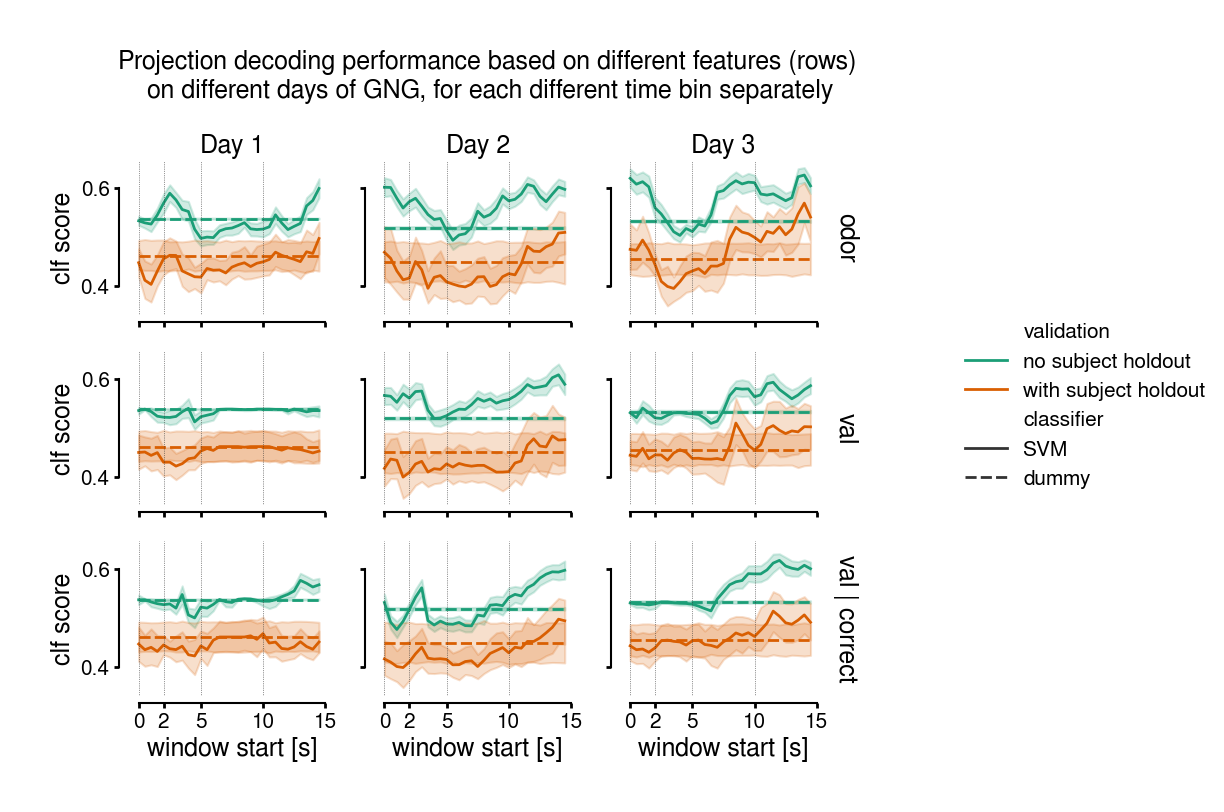

In [38]:
g = sns.relplot(
    (
        perf_df
        .query('not feature_cols.str.contains("t_start")')
        .explode('scores')
    ),
    x = 't_start',
    y = 'scores',
    hue = 'validation',
    row = 'feature_source', 
    col = 'day_num',
    style = 'classifier',
    palette='Dark2',
    kind = 'line',
    aspect = 1.2,
    height = 2.5,
    linewidth = 2,
    facet_kws={'margin_titles':True}
)

[ax.axvline(x=x,lw=0.5,ls=':',c='.2')
 for x in [0,2,5,10]
 for _, ax in g.axes_dict.items()
]

plt.xlim([-1, 16])
plt.xticks([0,2,5,10,15])

g.set_titles(
    row_template = '{row_name}',
    col_template = 'Day {col_name}',
)
g.fig.suptitle('Projection decoding performance based on different features (rows) \non different days of GNG, for each different time bin separately',x=0.4)
g.set_xlabels('window start [s]')
g.set_ylabels('clf score')
g.despine(trim=True, offset=5)
g.tight_layout(h_pad=-0.5)

This again shows there are different windows for best decoding projection trgets. It is interesting that for using odorant identities, the late phases becme better during learning.

Using valence is quite interesting. It gets better with learning, especially for late phases. Using correct trials with valence-dependent responses makes it better as well.

However, this is only true for non holdout. With holdout the results are mixed, possibly because of the imbalanced number of subjects based on projection areas. 

Plus, the number of animals for GNG dataset is smaller than the passive datasets. 

It may be good to use other metrics such as F1 or metrics that takes into account class / group imbalance into account.

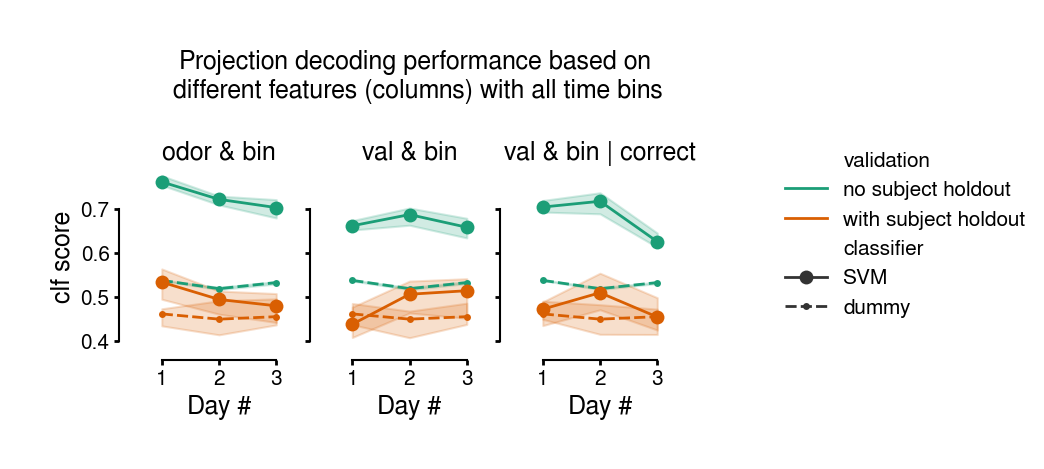

In [39]:
g = sns.relplot(
    (
        perf_df
        .query('feature_source.str.contains("\&")')
        .explode('scores')
    ),
    x='day_num',
    y='scores',
    hue = 'validation',
    col = 'feature_source', 
    palette='Dark2',
    kind = 'line',
    style = 'classifier',
    aspect = 0.6,
    n_boot = 20,
    height = 4,
    linewidth = 2,
    markersize=10,
    markers=['o', '.'],
    markeredgecolor='none',
    facet_kws={'margin_titles':True}
)
plt.xlim([0.5,3.5])
g.set_xlabels('Day #')
g.set_ylabels('clf score')
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Projection decoding performance based on \ndifferent features (columns) with all time bins',x=0.4)
g.despine(trim=True, offset=10)
g.tight_layout(w_pad=0)


Using all time bins seems to be good, though it does not not improve over learning.

It is possible that an SVM classifier is not well-fitted to figure out the trial-wise nuanced temporal dynamics. 

Hence, more sophisticaed models, especially ones that do not average activity across all trials, may help.

Plus, for GNG dataset, it would be interesting to see how model trained on one day performs on another.

Additionally, the tracked neurons are not yet taken into account in this notebook.